<a href="https://colab.research.google.com/github/Dipono/lebute/blob/main/Vehicle%E2%80%91type_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install required libraries
!pip install tensorflow matplotlib seaborn --quiet

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Path to dataset root folder
dataset_path = '/content/drive/MyDrive/Untitled folder/Vehicles'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Save class names
classes = list(train_generator.class_indices.keys())
print("Classes:", classes)


Found 4470 images belonging to 7 classes.
Found 1117 images belonging to 7 classes.
Classes: ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']


/tmp/ipython-input-4093816893.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


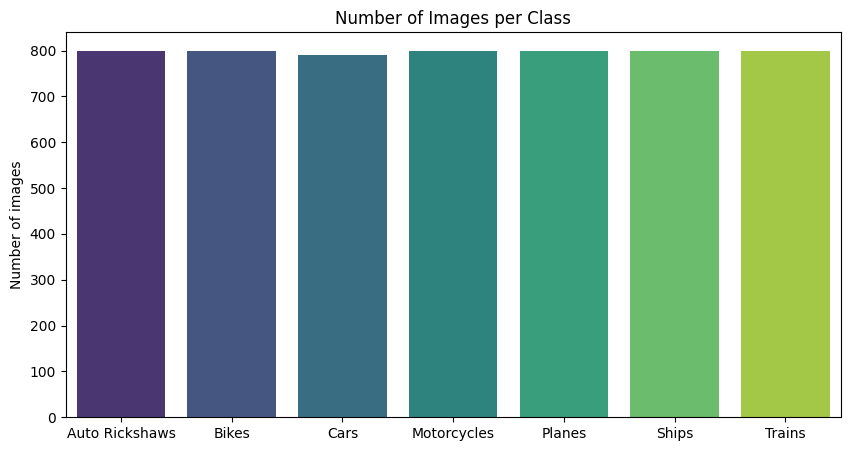

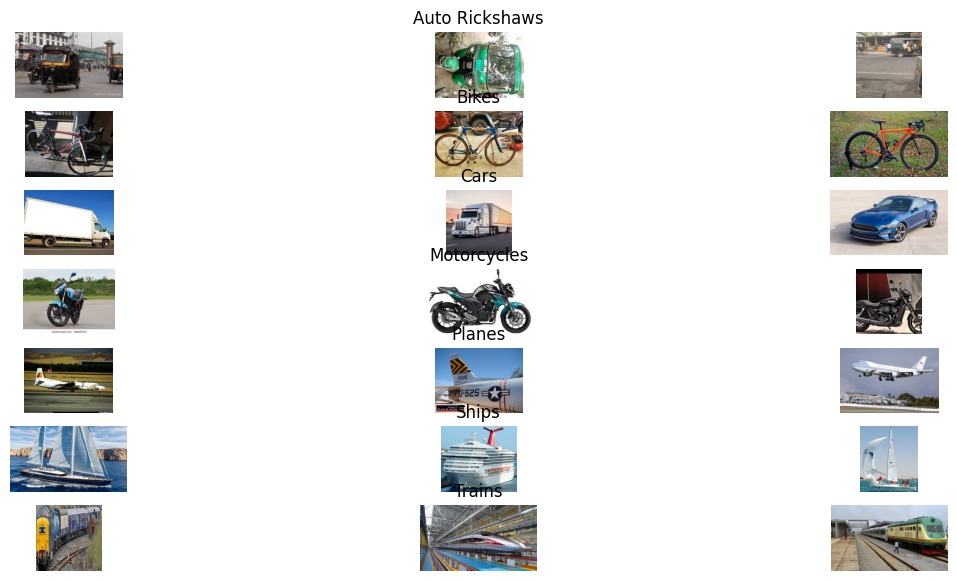

In [8]:
# Class distribution
counts = [len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes]
plt.figure(figsize=(10,5))
sns.barplot(x=classes, y=counts, palette="viridis")
plt.title("Number of Images per Class")
plt.ylabel("Number of images")
plt.show()

# Display sample images
def show_samples(dataset_path, classes, n=3):
    import matplotlib.image as mpimg
    import random
    plt.figure(figsize=(15, 7))
    for i, cls in enumerate(classes):
        imgs = os.listdir(os.path.join(dataset_path, cls))
        for j in range(n):
            img_path = os.path.join(dataset_path, cls, random.choice(imgs))
            plt.subplot(len(classes), n, i*n + j +1)
            plt.imshow(mpimg.imread(img_path))
            plt.axis('off')
            if j == 1:
                plt.title(cls)
show_samples(dataset_path, classes)


In [9]:
# Load pretrained ResNet50 without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
# Callbacks for training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  8/140 ━━━━━━━━━━━━━━━━━━━━ 1:01:39 28s/step - accuracy: 0.1606 - loss: 2.5082

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 4636s 33s/step - accuracy: 0.1933 - loss: 2.0490 - val_accuracy: 0.2883 - val_loss: 1.7363 - learning_rate: 0.0010
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 991s 7s/step - accuracy: 0.2938 - loss: 1.7456 - val_accuracy: 0.3671 - val_loss: 1.6464 - learning_rate: 0.0010
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1008s 7s/step - accuracy: 0.3450 - loss: 1.6638 - val_accuracy: 0.4127 - val_loss: 1.5891 - learning_rate: 0.0010
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 987s 7s/step - accuracy: 0.3449 - loss: 1.6290 - val_accuracy: 0.4414 - val_loss: 1.5396 - learning_rate: 0.0010
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1004s 7s/step - accuracy: 0.3702 - loss: 1.6004 - val_accuracy: 0.3957 - val_loss: 1.5576 - learning_rate: 0.0010
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1032s 7s/step - accuracy: 0.3857 - loss: 1.5870 - val_accuracy: 0.4100 - val_loss: 1.4952 - learning_rate: 0.0010
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1000s 7s/step - accuracy: 0.4003 - loss: 1.5627 

In [11]:
# Unfreeze last 50 layers for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Re-compile with lower learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1646s 12s/step - accuracy: 0.2945 - loss: 2.8971 - val_accuracy: 0.3124 - val_loss: 1.9930 - learning_rate: 1.0000e-05
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1612s 12s/step - accuracy: 0.4711 - loss: 1.4287 - val_accuracy: 0.5022 - val_loss: 1.2940 - learning_rate: 1.0000e-05
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1611s 12s/step - accuracy: 0.5259 - loss: 1.2563 - val_accuracy: 0.5819 - val_loss: 1.1190 - learning_rate: 1.0000e-05
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1623s 12s/step - accuracy: 0.5440 - loss: 1.2011 - val_accuracy: 0.6124 - val_loss: 1.0333 - learning_rate: 1.0000e-05
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1637s 12s/step - accuracy: 0.5934 - loss: 1.1350 - val_accuracy: 0.6410 - val_loss: 1.0202 - learning_rate: 1.0000e-05
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1622s 12s/step - accuracy: 0.6105 - loss: 1.0802 - val_accuracy: 0.6204 - val_loss: 1.0526 - learning_rate: 1.0000e-05
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1606s 

35/35 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step
                precision    recall  f1-score   support

Auto Rickshaws       0.74      0.51      0.60       160
         Bikes       0.82      0.87      0.84       160
          Cars       0.45      0.42      0.44       158
   Motorcycles       0.77      0.69      0.73       160
        Planes       0.54      0.83      0.65       159
         Ships       0.59      0.72      0.65       160
        Trains       0.72      0.46      0.56       160

      accuracy                           0.64      1117
     macro avg       0.66      0.64      0.64      1117
  weighted avg       0.66      0.64      0.64      1117



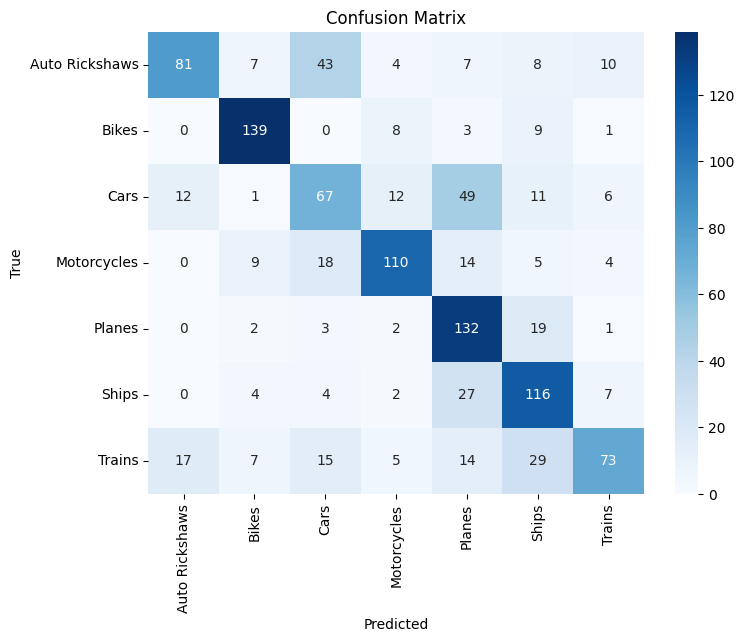

In [12]:
# Predict validation images
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


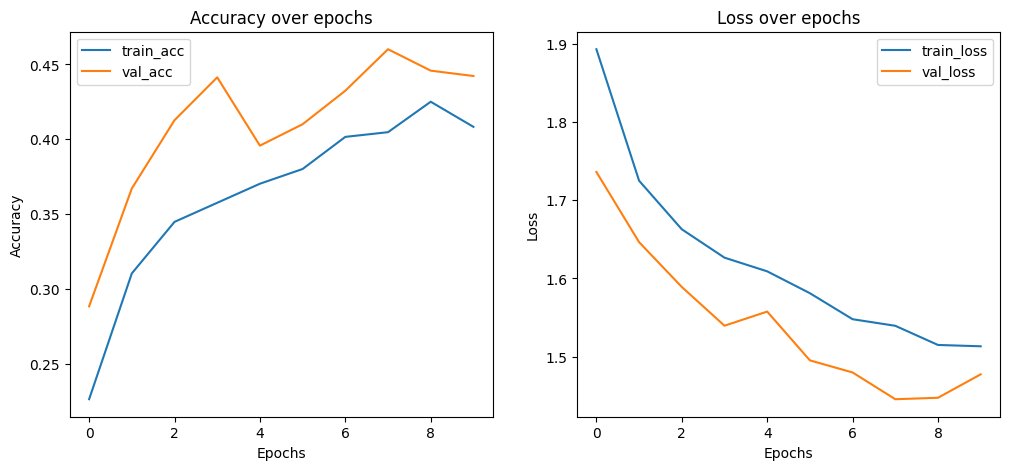

In [13]:
# Training & validation accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training & validation loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
# Save the trained model
model.save('/content/drive/MyDrive/Untitled folder/Vehicles/vehicle_classification_model.h5')
print("Model saved successfully!")

Model saved successfully!
